# Custom Named Entity Recognition on Medical Data

Named entity recognition (NER for short) is an aspect of natural language processing that is used to extract words of interest in a block of text. 

Many natural language processing models like spacy, bert etc are trained to recognize different words in a corpus, a paragraph or an article. These models have been trained on massive data and they come handy for general categories like name of a person, country, and organization. Spacy also has some scispacy models that you can download and use to recognise medical  words, drugs and chemicals.

However, you will most likely have words of interest that the pretrained models can’t recognise. In that case, you will need to train a model for your use case. Depending on the field, the words of interest are annotated and used to train a chosen NER model. In this tutorial, we’ll try our hands on training a custom NER model using a blank spacy model.

Spacy has pre-trained small, medium and large models. It also has scispacy which is a library containing models that can be used to extract illnesses, drugs and chemicals. It has been noted that it’s challenging to retrain a pre-trained spacy library in order to add new words to the model. To this end, we need to take a blank medium spacy model and train it with our annotated data from scratch.

We are going to use a dataset from kaggle which is already annotated. You can download the data from this link. 

https://www.kaggle.com/datasets/finalepoch/medical-ner



## Import the necessary libraries


In [1]:
import spacy
import json
from spacy import displacy
from spacy.tokens import Doc, DocBin
from spacy.util import filter_spans
from tqdm import tqdm

You need to download the large version of spacy model for more accuracy.



In [4]:
!python -m spacy download en_core_web_lg --user

     ------------------------------------ 400.7/400.7 MB 388.2 kB/s eta 0:00:00

DEPRECATION: https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.3.0/en_core_web_lg-3.3.0-py3-none-any.whl#egg=en_core_web_lg==3.3.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617



[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In order to use the model, we’ll load it and assign it to a variable


In [5]:
nlp = spacy.load("en_core_web_lg")
nlp

Let’s try it on a simple sentence.

In [6]:
doc = nlp('Elephants are found in Africa and India')

Spacy ner has a number of properties that we can check. One of them is doc.ents which shows us the entities that spacy is able to recognise. We can see that spacy model has recognized two entities in this sentence.


In [7]:
doc.ents

(Africa, India)

We can display the entities using displacy library from spacy.


In [8]:
displacy.render(doc, style="ent", jupyter=True)

## Custom NER


In order to find custom entities that may not be in spacy’s model, we can annotate our own text data and train a blank spacy model to recognise our own specific entities. However, we are going to download data from kaggle that comprises text data and annotated entities and other metadata in json format.

https://www.kaggle.com/datasets/finalepoch/medical-ner

Open a folder and extract the Corona2.json file. Load the json file and assign it to a variable.


In [9]:
# import json
with open('Corona2.json', 'r') as file:
    data = json.load(file)

Let's check a sample of the data.

In [10]:
data['examples'][1]

{'id': '487c93e3-0d45-4088-a378-cf3a01c8953d',
 'content': 'Diarrhea, also spelled diarrhoea, is the condition of having at least three loose, liquid, or watery bowel movements each day.[2] It often lasts for a few days and can result in dehydration due to fluid loss.[2] Signs of dehydration often begin with loss of the normal stretchiness of the skin and irritable behaviour.[2] This can progress to decreased urination, loss of skin color, a fast heart rate, and a decrease in responsiveness as it becomes more severe.[2] Loose but non-watery stools in babies who are exclusively breastfed, however, are normal.[2]',
 'metadata': {},
 'annotations': [{'id': '28601a42-c8a9-44e2-aeea-8939cb1db1a9',
   'tag_id': '03eb3e50-d4d8-4261-a60b-fa5aee5deb4a',
   'end': 382,
   'start': 364,
   'example_id': '487c93e3-0d45-4088-a378-cf3a01c8953d',
   'tag_name': 'MedicalCondition',
   'value': 'loss of skin color',
   'correct': None,
   'human_annotations': [{'timestamp': '2020-03-21T00:23:08.961000Z

The data is a nested json object. Let’s see the keys.

Let’s view what each key contains.


In [11]:
data['examples'][1].keys()

dict_keys(['id', 'content', 'metadata', 'annotations', 'classifications'])

In [12]:
data['examples'][1]['content']

'Diarrhea, also spelled diarrhoea, is the condition of having at least three loose, liquid, or watery bowel movements each day.[2] It often lasts for a few days and can result in dehydration due to fluid loss.[2] Signs of dehydration often begin with loss of the normal stretchiness of the skin and irritable behaviour.[2] This can progress to decreased urination, loss of skin color, a fast heart rate, and a decrease in responsiveness as it becomes more severe.[2] Loose but non-watery stools in babies who are exclusively breastfed, however, are normal.[2]'

In [13]:
data['examples'][1]['annotations'][0]

{'id': '28601a42-c8a9-44e2-aeea-8939cb1db1a9',
 'tag_id': '03eb3e50-d4d8-4261-a60b-fa5aee5deb4a',
 'end': 382,
 'start': 364,
 'example_id': '487c93e3-0d45-4088-a378-cf3a01c8953d',
 'tag_name': 'MedicalCondition',
 'value': 'loss of skin color',
 'correct': None,
 'human_annotations': [{'timestamp': '2020-03-21T00:23:08.961000Z',
   'annotator_id': 1,
   'tagged_token_id': '28601a42-c8a9-44e2-aeea-8939cb1db1a9',
   'name': 'Ashpat123',
   'reason': 'exploration'}],
 'model_annotations': []}

 We need the content and annotations.

## Extract the contents and annotations

Below, we’ll extract the content and annotations and use them to train the blank spacy model that we created above.

In the code above, 
1. We created an empty list for our training data.
2. We ran a for loop on each sample of our data, created an empty dictionary to hold the text and the custom entities. 
3. The text will be an list of the content while the custom entities will be an array of tuples that will hold the annotations, start index and end index of the location of the custom entity in the text.
4. We ran another for loop to append the text and the custom entities to the empty dictionary.
5. Finally, we append all the dictionaries to the empty train data array we created earlier.


In [14]:
train_data = []
for example in data['examples']:
    ent_dict = {}
    ent_dict['text'] = example['content']
    ent_dict['entities'] = []
    for annotation in example['annotations']:
        start = annotation['start']
        end = annotation['end']
        label = annotation['tag_name'].upper()
        ent_dict['entities'].append((start, end, label))
    train_data.append(ent_dict)

print(train_data[1])

{'text': 'Diarrhea, also spelled diarrhoea, is the condition of having at least three loose, liquid, or watery bowel movements each day.[2] It often lasts for a few days and can result in dehydration due to fluid loss.[2] Signs of dehydration often begin with loss of the normal stretchiness of the skin and irritable behaviour.[2] This can progress to decreased urination, loss of skin color, a fast heart rate, and a decrease in responsiveness as it becomes more severe.[2] Loose but non-watery stools in babies who are exclusively breastfed, however, are normal.[2]', 'entities': [(364, 382, 'MEDICALCONDITION'), (0, 8, 'MEDICALCONDITION'), (94, 116, 'MEDICALCONDITION'), (178, 189, 'MEDICALCONDITION'), (221, 232, 'MEDICALCONDITION'), (23, 32, 'MEDICALCONDITION'), (409, 435, 'MEDICALCONDITION'), (386, 401, 'MEDICALCONDITION')]}


Let’s see what we were able to extract.

This is a sample text


In [15]:
train_data[1]['text']

'Diarrhea, also spelled diarrhoea, is the condition of having at least three loose, liquid, or watery bowel movements each day.[2] It often lasts for a few days and can result in dehydration due to fluid loss.[2] Signs of dehydration often begin with loss of the normal stretchiness of the skin and irritable behaviour.[2] This can progress to decreased urination, loss of skin color, a fast heart rate, and a decrease in responsiveness as it becomes more severe.[2] Loose but non-watery stools in babies who are exclusively breastfed, however, are normal.[2]'

This is a sample of entities in a text


In [16]:
train_data[1]['entities']

[(364, 382, 'MEDICALCONDITION'),
 (0, 8, 'MEDICALCONDITION'),
 (94, 116, 'MEDICALCONDITION'),
 (178, 189, 'MEDICALCONDITION'),
 (221, 232, 'MEDICALCONDITION'),
 (23, 32, 'MEDICALCONDITION'),
 (409, 435, 'MEDICALCONDITION'),
 (386, 401, 'MEDICALCONDITION')]

We can also check the entity in a particular index

In [17]:
train_data[1]['text'][364:382]

'loss of skin color'

Let’s view a sample train data

In [18]:
train_data[5]

{'text': "Hantaviruses, usually found in rodents and shrews, were discovered in two species of bats. The MouyassuÃ© virus (MOUV) was isolated from banana pipistrelle bats captured near MouyassuÃ© village in Cote d'Ivoire, West Africa. The Magboi virus was isolated from hairy slit-faced bats found near the Magboi River in Sierra Leone in 2011. They are single-stranded, negative sense, RNA viruses in the Bunyaviridae family.[29][30][31][32]",
 'entities': [(0, 12, 'PATHOGEN'),
  (394, 406, 'PATHOGEN'),
  (227, 239, 'PATHOGEN'),
  (95, 110, 'PATHOGEN')]}

## Build the model

 We need to initialize a blank spacy model to build our custom NER model.

In [19]:
nlp = spacy.blank('en')
doc_bin = DocBin()

Spacy expects our data to be in the form of a DocBin object. 

In the code below,
1. We ran a for loop on the train data that we extracted from the json file. We wrap the train data in tqdm to show us the progress bar.
2. We extract the text of each train_doc as text and entities of each train_doc as labels. The labels have start, end and the entity label.
3. We convert this to spacy doc with make_doc function from spaCy.
4. We initialize an empty list ents to hold all the entities.
5. We convert the doc to a span object with doc.char_span.
6. We then pass the list of entities to filter_span which ensures that there are no duplicate entities.
7. We saved the filtered entities into doc.ents and then, we add the doc.ents to the doc_bin instance.
8. Finally, we saved the doc_bin instance to disk with the name custom_ner that we chose. You should find the custom_ner.spacy file in the same directory.

In [20]:
for train_doc in tqdm(train_data):
    text = train_doc['text']
    labels = train_doc['entities']
    doc = nlp.make_doc(text)
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode='contract')
        if span is None:
            print('No Span found')
        else:
            ents.append(span)
    final_ents = filter_spans(ents)
    doc.ents = final_ents
    doc_bin.add(doc)
    
doc_bin.to_disk('custom_ner.spacy')

 29%|██▉       | 9/31 [00:00<00:00, 44.71it/s]

No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found


100%|██████████| 31/31 [00:00<00:00, 66.28it/s]

No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found
No Span found


## Train the model

The spacy model expects a configuration file which we can build with the help of spacy on their website in this link:
https://spacy.io/usage/training#quickstart

It should look like this. Then, copy the config file, paste it in new file in the same directory and name it base_config.cfg.

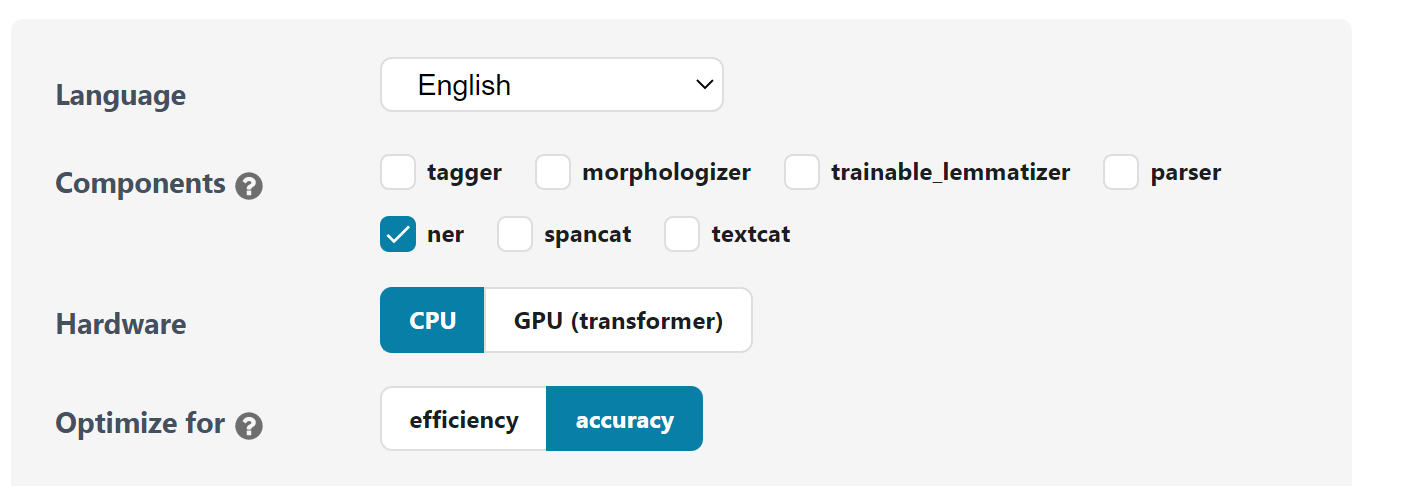


Then run this command so that spaCy will use the base_config file to create a new config.cfg file.

In [21]:
!python -m spacy init fill-config base_config.cfg config.cfg

[+] Auto-filled config with all values
[+] Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [22]:
!python -m spacy train config.cfg --output ./output --paths.train ./custom_ner.spacy --paths.dev ./custom_ner.spacy

[+] Created output directory: output
[i] Saving to output directory: output
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001

[2023-03-09 00:38:59,631] [INFO] Set up nlp object from config
[2023-03-09 00:38:59,728] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-03-09 00:38:59,754] [INFO] Created vocabulary
[2023-03-09 00:39:14,911] [INFO] Added vectors: en_core_web_lg
[2023-03-09 00:39:28,844] [INFO] Finished initializing nlp object
[2023-03-09 00:39:38,310] [INFO] Initialized pipeline components: ['tok2vec', 'ner']



E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    150.79    0.45    0.31    0.81    0.00
  7     200        337.18   3355.81   81.45   80.80   82.11    0.81
[+] Saved pipeline to output directory
output\model-last


In [23]:
custom_med_NER = spacy.load('output/model-best')

In [24]:

docx = custom_med_NER('Diarrhea, also spelled diarrhoea, is the condition of having at least three loose, liquid, or watery bowel movements each day.[2] It often lasts for a few days and can result in dehydration due to fluid loss.[2] Signs of dehydration often begin with loss of the normal stretchiness of the skin and irritable behaviour.[2] This can progress to decreased urination, loss of skin color, a fast heart rate, and a decrease in responsiveness as it becomes more severe.[2] Loose but non-watery stools in babies who are exclusively breastfed, however, are normal')

colors= {'PATHOGEN': '#D49137', 'MEDICINE': '#BE398D', 'MEDICALCONDITION': '#F07857'}
options = {'colors': colors}

spacy.displacy.render(docx, style='ent', options=options, jupyter=True)

In [28]:
doc2 =  """Influenza, commonly known as "the flu", is an infectious disease caused by influenza viruses. 
          Symptoms range from mild to severe and often include fever, runny nose, sore throat, muscle pain, 
          headache, coughing, and fatigue. These symptoms begin from one to four days after exposure to t
          he virus (typically two days) and last for about 2–8 days. Diarrhea and vomiting can occur, 
          particularly in children. Influenza may progress to pneumonia, which can be caused by the virus or 
          by a subsequent bacterial infection. Other complications of infection include acute respiratory 
          distress syndrome, meningitis, encephalitis,
          and worsening of pre-existing health problems such as asthma and cardiovascular disease."""

In [31]:
result2 = custom_med_NER(doc2)

spacy.displacy.render(result2, style='ent', options=options, jupyter=True)

In [36]:
doc3 = """Frequent coughing usually indicates the presence of a disease. Many viruses and bacteria benefit,
from an evolutionary perspective, by causing the host to cough, which helps to spread the disease to new hosts. 
Most of the time, irregular coughing is caused by a respiratory tract infection but can also be triggered 
by choking, smoking, air pollution,[1] asthma, gastroesophageal reflux disease, 
post-nasal drip, chronic bronchitis, lung tumors, heart failure and medications such as 
angiotensin-converting-enzyme inhibitors (ACE inhibitors) and beta blockers.[2]
Treatment should target the cause; for example, smoking cessation or discontinuing ACE inhibitors.
Cough suppressants such as codeine or dextromethorphan are frequently prescribed, but have been 
demonstrated to have little effect. Other treatment options may target airway inflammation or 
may promote mucus expectoration. As it is a natural protective reflex, suppressing the cough 
reflex might have damaging effects, especially if the cough is productive."""

In [37]:
result3 = custom_med_NER(doc3)
spacy.displacy.render(result3, style='ent', options=options, jupyter=True)

## Conclusion


We tried our hands on building a named entity recognition model to recognize three classes of words in medical data. The model was trained for only 100 epochs and is not perfect, but still, it was able to recognize some of the words.

In the near future, I'll build a front end application with flask and html and deploy it on github pages so that a user can try the model directly in the browser.

Disclaimer: This article is meant for sharing knowledge. It's not meant to diagnose nor treat any ailment.